# Computational Materials Discovery - a primer



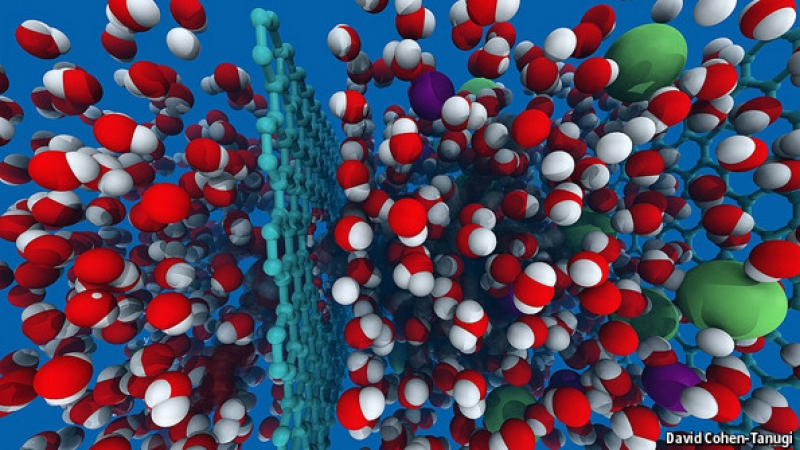
<i>Desalinating water using Graphene. Image from article in <a href = "https://www.economist.com/babbage/2013/04/04/allo-allo">the Economist</a></i>  



### <i>Materials make our world</i>.  



Does this statement seem corny and hyperbolic at first sight? I'd have to agree. While that may be true, I also hold that the statement is a self-evident truth. Still skeptical? Good. You have reasons to read on.

To make my case, let's run through a typical morning routine. You wake up, you brush your teeth using a plastic tootbrush with nylon bristles. You use a ceramic toilet. The stainless steel showerhead pours cleansing water on you. You eat breakfast while checking your phone made of a metallic alloy and coated with unbreakable Glass. Oh, and that phone contains a microprocessor chip that houses within it materials comprised of greater than 30 elements in the periodic table. You then leave for work in a car that likely has a frame strengthened with composites. You spend your day staring at an LCD/LED screen that receives display instructions from a slightly larger microprocessor chip that...is also made of materials that run the gamut of elements in the periodic table.

I won't belabor the point further. Hopefully you've caught on to my drift by now. We take these materials and the conveniences they enable for granted. This is as it should be. We shouldn't spend each moment of our waking lives worrying about how things were made. But I think it is useful to pause and reflect upon how these materials get into objects of daily use.

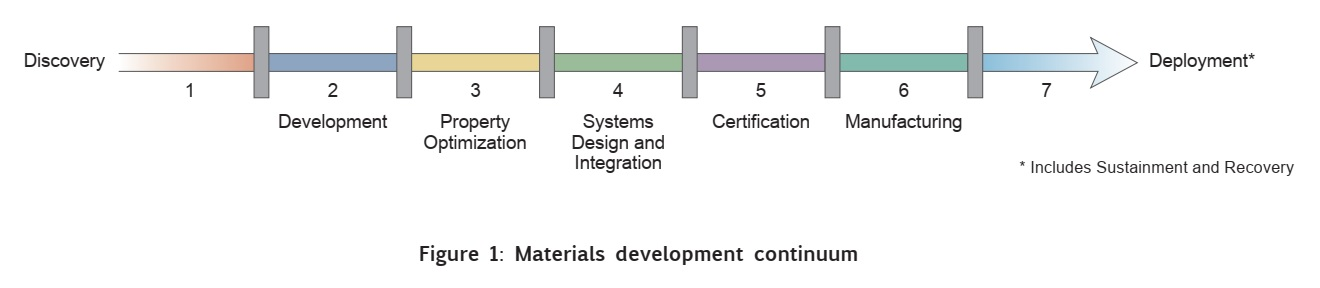
<i>Figure source: <a href = "https://www.mgi.gov/sites/default/files/documents/materials_genome_initiative-final.pdf">Materials Genome Initiative</i>

A promising material candidate is identified for an application. This step is then succeeded by several stages - development, optimization, design, certification, manufacturing and finally, deployment. The <a href = "https://www.mgi.gov/sites/default/files/documents/materials_genome_initiative-final.pdf">Materials Genome Initiative</a> estimates a timeframe of 10 to 20 years for the above process. Not to mention the fact that the discovery process itself is prone to trial-and-error and extremely time consuming. 

Advances in computation have enabled the creation of a new field - <a href="https://iopscience.iop.org/article/10.1088/1361-6463/aad926/pdf">Computational materials discovery and design</a>  - that aims to make the process above more systematic and less time-consuming. The essential idea in computational materials discovery is to reject the costly and time-consuming trial-and-error phase of discovery driven by existing chemical intuition and brute-force experimentation in favor of highly-accurate and targeted data-driven approaches.

In other words, before conducting physical experiments, one steps back, does a detailed analysis of existing materials databases or generates new data based on the fundamental physics of materials, and generates a list of promising materials suited for targeted physical properties. 

In this post, I aim to give the reader a brief but hopefully informative snapshot of the computational materials discovery process. In the interest of simplicity, I use the <a href='https://en.wikipedia.org/wiki/Electron_configuration'>Electronic Configuration</a> of atoms to group materials and find materials having properties similar to industrially relevant materials.

At the outset, I caution that the post is not intended to be exhaustive conceptually. Instead, I hope to convey a sense for how the problem of materials discovery can be tackled using a principled, data-based approach using computational tools that are free and easily accessible.

The rest of this post is organized as follows. First, I attempt to provide an intuitive explanation of the concept of average electronic configuration of materials. I then describe the use of two Python software packages - <a href = "http://http://pymatgen.org/">pymatgen</a> and <a href = "https://hackingmaterials.github.io/matminer/">matminer</a> - in creating a database of the valence electron configuration of a large number of inorganic materials. I then outline specific questions in the context of materials similarity and discovery that can be answered by performing a detailed analysis of database. Each subsequent section provides answers to these questions in the form of visualizations and tables. The last section provides key take-home messages from the analysis and some suggestions for expanding and improving upon the analysis in this post. Accompanying code for this post can be found at my repository on <a href = "https://github.com/g-hegde/material-similarity">GitHub</a>. 

### Electronic configuration

The <a href='https://en.wikipedia.org/wiki/Electron_configuration'>Electronic Configuration</a> of atoms describes how electrons are distributed in an atom. In a broad sense, atoms are comprised of

* A central core called the nucleus, which contains neutrons and positively-charged protons  
* Negatively-charged electrons that orbit the nucleus

Electrons orbiting the nucleus do so in spatial configurations called orbitals at multiple energy levels (shells). Orbitals come essentially in 5 different flavors - s, p, d, f and g. Each orbital can hold a maximum of 2 electrons. At each energy level, one has a combination of s and/or p, d, f and g orbitals. s-orbitals are spherically symmetric and there is consequently only one s orbital for each energy level. There are 3 and 5 p and d orbitals respectively for energy levels in which these orbitals exist. Valence electrons are electrons that occupy the outermost energy levels. These are less-bound to the nucleus and are consequently freer to move through the body of the material. Valence electrons and their resulting configuration is what determines bonding and chemical properties of a material. The picture below shows the Valence Electronic Configuration (VEC) of elements in the periodic table.

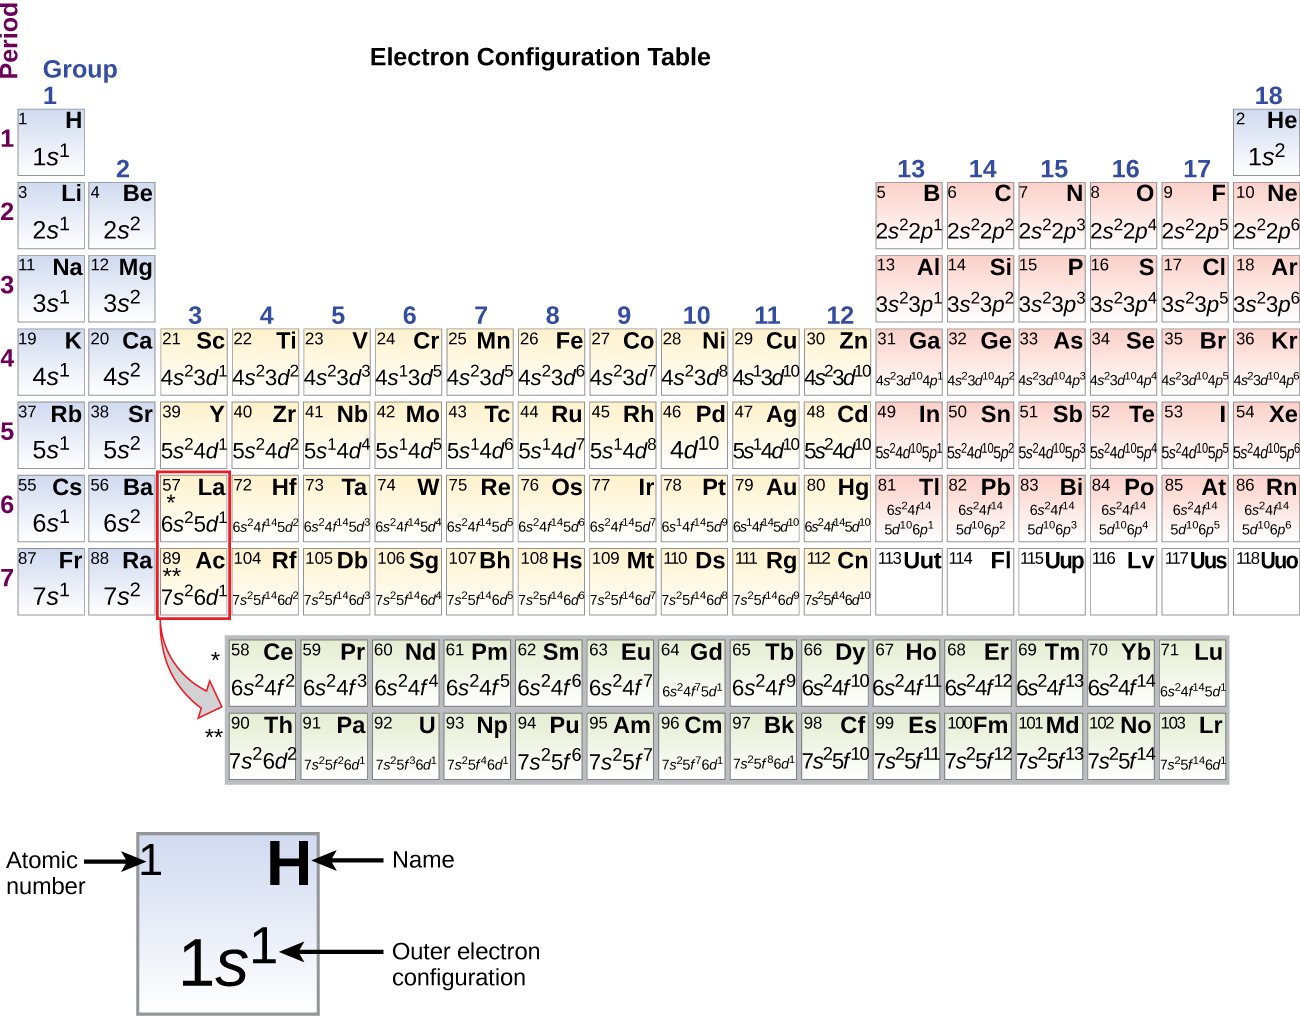  
<i>Image from <a href = "https://opentextbc.ca/chemistry/chapter/6-4-electronic-structure-of-atoms-electron-configurations/">OpenBC Textbook</a></i>

The VEC of materials is one of their most fundamental physical properties. Knowledge of the VEC of atoms in materials can help us understand and predict a wide range of their physical and chemical properties. For instance, knowledge of the VEC of Silicon (3s$^2$3p$^2$) explains why it is a semiconductor. Or why Copper, Silver and Gold (ns$^1$(n-1)d$^{10}$) are metals.

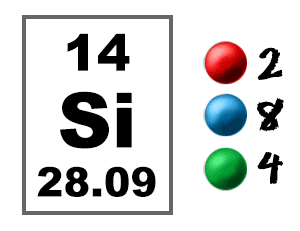 
<i><a href = "http://www.chem4kids.com/files/elements/014_shells.html">Silicon Electronic shell levels</a>. The Valence Electronic Configuration of Silicon is 3s$^2$3p$^2$. The outermost shell (3) contains a filled s orbital and two partially filled p orbitals</i>  

Developing a deep understanding of electronic configuration requires extensive knowledge of atomic physics and chemistry. This is because, at a fundamental level, the behavior of all materials is governed by the rules of <a href="https://en.wikipedia.org/wiki/Quantum_mechanics">Quantum Mechanics</a>. Needless to say, this is beyond the scope of a single blog post. It is useful instead to focus on understanding how the VEC changes from one atom/material to another.

The periodic table above shows the VEC of all elemental materials (The terms elemental/unary/mono-atomic will be used interchangeably here). For compound materials such as binary materials (materials comprised of two elements) and ternary materials (three elements), such a straightforward comparison is not possible.

### Average electronic configuration

For materials containing multiple elements, a simple tweak to valence electronic structure is obtained as follows. An <a href = "http://chemed.chem.purdue.edu/genchem/topicreview/bp/ch13/unitcell.php">Unit Cell</a> of a material is a repeatable unit of atoms of a material. When this unit is repeated uniformly in all spatial dimensions, we obtain a crystal of the material. By summing the VEC of each atom in the Unit Cell and dividing through by the number of atoms in the unit cell we obtain the average VEC.

Having seen what the average VEC is, we can put this knowledge to use in a simple materials discovery case study.

### Materials-Discovery case-study  

We have a material that we seek to replace with another cheaper, equally performing alternative. As a Computational Materials Discovery scientist, it is your responsibility to create a database with relevant VEC information for all possible elements and compounds that may be suitable replacements for this material. You are then required to clean this database to ensure the fidelity of all the data in the database. After this, you are required to perform unsupervised machine learning to see which materials group together. The set of materials closest to the target material can then be pushed up the chain for further consideration as replacement candidates.

### Relevant questions  
* When materials are represented on the basis of their average Valence Electronic Configuration (VEC), what is the optimum number of clusters that they can be grouped into?  
* What materials are represented by cluster centers? Alternately, what unary material/materials are closest to cluster centers? 
* Does the grouping make intuitive sense - i.e. are the cluster centers sufficiently far away from each other on the basis of chemical intuition?  
* Given a target material, say Copper, what is the material (unary, binary and ternary respectively) whose VEC most closely resembles that of Copper? Performing such an analysis Copper interconnects</a> in the semiconductor industry.
* Given a target material, say Copper, what is the (binary and ternary) nitride material whose average VEC most closely resembles that of Copper?  Performing such an analysis could be useful for finding suitable diffusion barrier materials for Copper interconnects.

### Step 1: Gather data

In [377]:
#import relevant packages
import numpy as np
import pandas as pd
import pymatgen as mg
import matplotlib.pyplot as plt
from matminer.featurizers.composition import ValenceOrbital 
from matminer.featurizers.conversions import StructureToComposition
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances,pairwise_distances_argmin
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

%matplotlib inline

To gather relevant data, connect to the <a href = "https://www.materialsproject.org">Materials Project</a> API. This can be done using the <a href= "http://pymatgen.org">pymatgen</a> library. Define an MPRester object that can be used to query the Materials Project.

In [378]:
#define a MPRester object
mpr = mg.MPRester(api_key='zUTBDkOXNL4RpPaQ')

Next, we create a function to fetch data from the Materials Project based on the number of elements in the material. These materials are respectively called 'unary', 'binary' and 'ternary'.

In [379]:
unary_list = mpr.get_data('*') # returns all data corresponding to mono-atomic materials in a list of dicts
unary = pd.DataFrame(unary_list)

In [380]:
binary_list = mpr.get_data('*-*') # returns all data corresponding to di-atomic materials in a list of dicts
binary = pd.DataFrame(binary_list)

For Ternary materials, the amount of data returned by the simple query ("*-*-*") is large enough that Materials Project automatically limits this transfer. To work around this limitation, we convert the problem of querying all ternary materials to a problem of querying ternary materials tagged by specific elements. This approach results in duplication of data, which can be taken care of in subsequent steps. In doing so, radioactive atoms and highly reactive (H, O, F, Cl, Br, I) or noble gases (He, Xe) were omitted from this list.

In [381]:
elem_list = ['Ag' ,'Al', 'As', 'Au', 'B', 'Be', 'Bi', 'C', 'Ca', 'Cd','Co','Cr','Cu','Fe','Ga','Ge',
             'Hf','Hg','In','Ir','K','La','Li','Mg','Mn','Mo','N','Na','Nb','Ni','Os','P','Pb','Pd',
             'Pt','Rh','Ru','S','Sb','Sc','Se','Si','Sn','Ta', 'Te','Ti','V','W','Y','Zn','Zr']

In [ ]:
ternary = pd.DataFrame()
for elem in elem_list:
    query = '*-*-'+elem #break-up query element-wise
    try:
        ternary_list = mpr.get_data(query)
        ternary = ternary.append(pd.DataFrame(ternary_list),ignore_index=True,verify_integrity=True)
    except Exception as e:
        print('Element for which we are getting this error -- {}'.format(elem))
        print(e)
        continue

Next we can filter out all materials that don't exist in the list of elements we used to create the ternary dataset.

In [750]:
unary = unary[[True if(set(cand_list).issubset(elem_list)) else False for cand_list in unary['elements'].tolist()]].copy()
binary = binary[[True if(set(cand_list).issubset(elem_list)) else False for cand_list in binary['elements'].tolist()]].copy()
ternary = ternary[[True if(set(cand_list).issubset(elem_list)) else False for cand_list in ternary['elements'].tolist()]].copy()

Next, the unary, binary and ternary databases are combined into a single dataset. Duplicates are removed.

In [848]:
materials_db = unary
materials_db = materials_db.append(binary,ignore_index=True,verify_integrity=True)
materials_db = materials_db.append(ternary,ignore_index=True,verify_integrity=True)
materials_db = materials_db.drop_duplicates(subset=['material_id'])

Check the number of unique materials in this dataset.

In [724]:
materials_db.shape[0]

25272

The next step is to create a PyMatGen "Composition" object (http://pymatgen.org/_modules/pymatgen/core/composition.html) for each unique material in the dataset. This step is a precursor to adding electronic structure related features to the dataset.

In [849]:
materials_db['composition'] = materials_db['pretty_formula'].apply(lambda x: mg.Composition(x))

The <a href="https://hackingmaterials.github.io/matminer/">matminer</a> package is a library that can be used to perform data mining of materials. It provides routines to query various materials databases, featurize existing databases and works natively within the Pandas DataFrame format. This makes the package extremely useful for this case study.  

The valence electronic structure of each material can be obtained from the <a href = "https://hackingmaterials.github.io/matminer/matminer.featurizers.html#matminer.featurizers.composition.ValenceOrbital">ValenceOrbital Featurizer </a> in matminer.  

For practical applications, we would be primarily interested in the 's', 'p' and 'd' orbital valence configurations.

In [850]:
vo = ValenceOrbital(orbitals=['s','p','d'],props=['avg'])
materials_db = vo.featurize_dataframe(df=materials_db,col_id='composition')

To examine the output of this step it is useful to check the names of the columns that result from the featurizing operation

In [542]:
materials_db.columns

Index(['band_gap', 'cif', 'density', 'diel', 'e_above_hull', 'elasticity',
       'elements', 'energy', 'energy_per_atom', 'formation_energy_per_atom',
       'full_formula', 'hubbards', 'icsd_id', 'icsd_ids', 'is_compatible',
       'is_hubbard', 'material_id', 'nelements', 'nsites', 'oxide_type',
       'piezo', 'pretty_formula', 'spacegroup', 'tags', 'task_ids',
       'total_magnetization', 'unit_cell_formula', 'volume', 'composition',
       'avg s valence electrons', 'avg p valence electrons',
       'avg d valence electrons'],
      dtype='object')

### Step 2. Assess Data

For simplicity, it is useful to separate out the relevant features into a separate dataset. We can then plot the distributions of relevant features and make a broad assessment of what the kind of analysis might be supported by this type of data.

In [851]:
valence_columns = ['avg s valence electrons', 'avg p valence electrons', 'avg d valence electrons']
materials_valence = materials_db[valence_columns].copy()

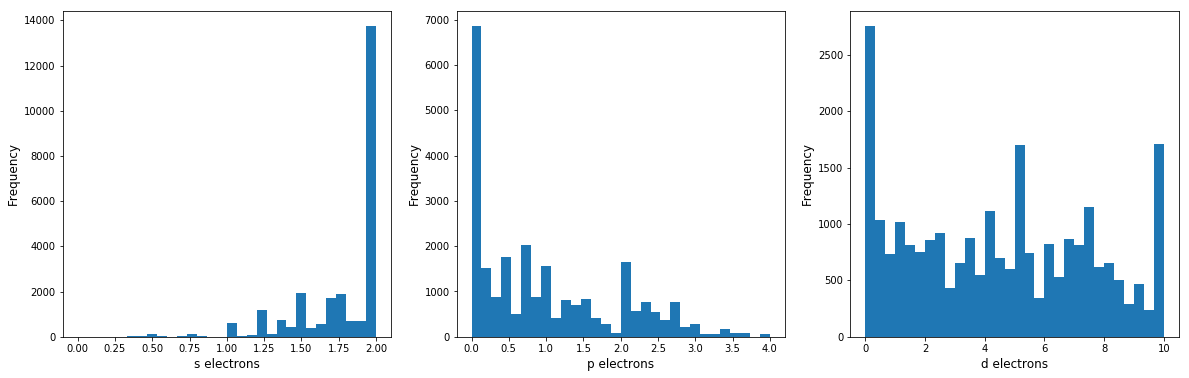

In [738]:
plt.figure(figsize=(20,6))
plt.subplot(1,3,1)
materials_valence['avg s valence electrons'].plot.hist(bins=30)
plt.xlabel('s electrons',fontsize=12)
plt.ylabel('Frequency',fontsize=12)
plt.subplot(1,3,2)
materials_valence['avg p valence electrons'].plot.hist(bins=30)
plt.xlabel('p electrons',fontsize=12)
plt.ylabel('Frequency',fontsize=12)
plt.subplot(1,3,3)
materials_valence['avg d valence electrons'].plot.hist(bins=30)
plt.xlabel('d electrons',fontsize=12)
plt.ylabel('Frequency',fontsize=12)
plt.show()

The distribution of s-electrons and p-electrons are almost diametrically opposite - The s distribution is heavily left-skewed, while the p-distribution is heavily right-skewed. The d-distribution has a comparatively more even distribution with a few spikes. 

What are the insights that we get from this assessment? First, left-skewed s data indicates that materials with unoccupied s-orbitals are far and few in the dataset. This is potentially disadvantageous if we are looking for exact replacements to materials that have unoccupied s orbitals - e.g. some materials from Group 1 and periods 4,5, and 6 in the periodic table and their combinations. 

The exact opposite is true of p orbitals - the number of materials with unoccupied p orbitals is large, while the number of materials with occupied p-orbitals is small. Inspecting the Periodic table above, the reason for this imbalance becomes clear - we excluded inert gases (which are pretty useless for our case study) and the highly reactive Fluorine-group elements. It also means that the dataset is skewed towards more metallic elements (and their compounds) on the left-side of the periodic table.
This assessment is also supported by the wide distribution of d electrons. The broad swathe of elements in the center of periodic table are largely d-type metals with a large degree of variation in d-electron occupancy.

What this means is that if we're looking for metals to replace, we're likely in luck. If, on the other hand we're looking to replace semiconductors (with fully occupied s orbitals and unoccupied p orbitals), we have fewer choices. A direct judgement on insulators cannot be made on the basis of this simplistic assessment.

### Step 3. Cleaning and preparing data for analysis

Before proceeding to data analysis it is useful to check for null values in the dataset. Since every material has a corresponding Composition object in pymatgen, it is unlikely that the dataset contains null values. In the unlikely event that null values are found, we can omit these values without loss of generality.

In [739]:
null_values = materials_valence.isnull().sum()
print(null_values)

avg s valence electrons    0
avg p valence electrons    0
avg d valence electrons    0
dtype: int64


Since there are no null values, we can continue analysis on this dataset unimpeded.
Prior to clustering, it is useful to scale the datset to ensure that no feature dominates the distance calculation.

In [852]:
scaler = StandardScaler()
mat_val_scaled = scaler.fit_transform(materials_valence)

In [853]:
materials_db['avg s valence electrons'] = mat_val_scaled[:,0]
materials_db['avg p valence electrons'] = mat_val_scaled[:,1]
materials_db['avg d valence electrons'] = mat_val_scaled[:,2]

### Step 4. Data Analysis, modeling and visualization

We are now in a position to perform clustering on the dataset to find the natural grouping of materials in the dataset.
A Simple KMeans clustering can be performed to begin with. We can first answer question 1 - When materials are represented on the basis of their average Valence Electronic Configuration (VEC), what is the optimum number of clusters that they can be grouped into? To do this, we perform clustering on the dataset using the KMeans algorithm implemented in scikit-learn.

In [775]:
num_clusters  = list(range(2,20))
inertia = []
for clusters in num_clusters:
    kmeans = KMeans(n_clusters=clusters)
    kmeans.fit(mat_val_scaled)
    inertia.append(kmeans.inertia_)

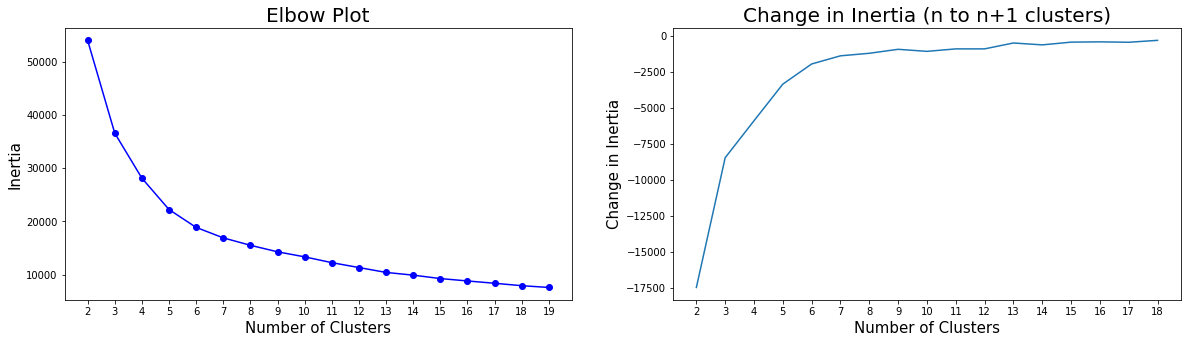

In [776]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(num_clusters,inertia,'bo-')
plt.xticks(num_clusters)
plt.xlabel('Number of Clusters',fontsize=15)
plt.ylabel('Inertia',fontsize=15)
plt.title('Elbow Plot',fontsize=20)
plt.subplot(1,2,2)
plt.plot(num_clusters[:len(num_clusters)-1],np.diff(inertia))
plt.xticks(num_clusters[:len(num_clusters)-1])
plt.xlabel('Number of Clusters',fontsize=15)
plt.ylabel('Change in Inertia',fontsize=15)
plt.title('Change in Inertia (n to n+1 clusters)',fontsize=20)
plt.show()

To determine the optimum number of clusters, we can use the <a href="https://en.wikipedia.org/wiki/Determining_the_number_of_clusters_in_a_data_set#The_elbow_method">Elbow Method</a>. In scikit-learn we can plot the inertia of the clustering operation (The sum of the squared distance of each point from the closest cluster) versus the number of clusters and see if an elbow exists. If it does, we can use the elbow point to determine the optimum number of clusters. If it doesn't we may need more anaysis.
It is difficult to visually determine if a distinct elbow exists in the inertia plot on the left. It is therefore useful to plot the rate of change of inertia when the number of clusters is increased. This plot shows a distinct 'knee' (continuing with anatomical metaphors) between n=3 and n=6. 

This provides a tentative answer to question 1 - It appears that the dataset based on average electronic structure can be partitioned into 3-6 distinct clusters. 

Next, we tackle questions questions 2 and 3 - What materials are represented by cluster centers? Alternately, what material/materials are closest to cluster centers? Does the grouping make intuitive sense - i.e. are the cluster centers sufficiently far away from each other on the basis of chemical intuition? 

In order to answer these questions, we need to first determine what the cluster centers are for the optimum number of clusters (n=4 through 6). Let's fix n_clusters = 4 and re-fit KMeans.

In [822]:
kmeans = KMeans(n_clusters=4,random_state=45)
kmeans.fit(mat_val_scaled)
cluster_centers = kmeans.cluster_centers_

We now need a way to compare the distance of each material in the (scaled) dataset to each cluster center. Once we have this measure, we can find which material or group of materials most closely resembles the center. We can then choose this material to be (roughly) representative of its respective cluster.

The Scikit-Learn package provides such a method - pairwise_distances. Each Vector in matrix X is compared to each vector in matrix Y and a vector corresponding to the pairwise distances is returned for each Vector in Y.

In [827]:
distances = pairwise_distances(X=mat_val_scaled,Y=cluster_centers,metric='euclidean')

distances_to_centroid_1 = distances[:,0]
distances_to_centroid_2 = distances[:,1]
distances_to_centroid_3 = distances[:,2]
distances_to_centroid_4 = distances[:,3]

We can now assign these distances as columns to the original dataset and make use of the sorting functions that pandas provides in order to find the materials closest to cluster centers and print them out. In order to aid chemical intuition, we can also check which elemental materials are closest to the cluster centers. Since the properties of elemental solids are generally more familiar to people - Cu is a noble-metal, Si is a semiconductor, Na is an alkali metal for instance - it makes the comparison more accessible.

In [828]:
materials_db['distance_1'] = distances_to_centroid_1
materials_db['distance_2'] = distances_to_centroid_2
materials_db['distance_3'] = distances_to_centroid_3
materials_db['distance_4'] = distances_to_centroid_4

In [802]:
materials_db.sort_values(by=['distance_1'],ascending=True,axis=0,inplace=True)
materials_db[['material_id','pretty_formula','distance_1']].head(1)

,material_id,pretty_formula,distance_1
953,mp-16960,AlPt2,0.102824


AlPt$_2$ is (one, among many) of the materials closest to the centroid of cluster 1. 

In [692]:
materials_db.sort_values(by=['nelements','distance_1'],ascending=True,axis=0,inplace=True)
materials_db[['material_id','pretty_formula','distance_1']].head(1)

,material_id,pretty_formula,distance_1
393,mp-109,Si,0.618399


Ruthenium (Ru) is the unary material/elemental material/mono-atomic material closest to cluster 1. It should be noted that the distance of Ru from the center of cluster 1 is an order of magnitude larger than that of the closest material, which is CrGaSe$_3$.

In [489]:
materials_db.sort_values(by=['distance_2'],ascending=True,axis=0,inplace=True)
materials_db[['material_id','pretty_formula','distance_2']].head(1)

,material_id,pretty_formula,distance_2
29282,mp-777019,Li8SbS6,0.184025


Li$_8$SbS$_6$ is one of the materials closest to center of cluster 2.

In [693]:
materials_db.sort_values(by=['nelements','distance_2'],ascending=True,axis=0,inplace=True)
materials_db[['material_id','pretty_formula','distance_2']].head(1)

,material_id,pretty_formula,distance_2
219,mp-1199937,K,0.785192


Carbon (C) is one of the elemental materials closest to center of cluster 2. As is the case for Ru, the distance of C from cluster center is significantly higher than that of the closest material Li$_8$SbS$_6$

In [491]:
materials_db.sort_values(by=['distance_3'],ascending=True,axis=0,inplace=True)
materials_db[['material_id','pretty_formula','distance_3']].head(1)

,material_id,pretty_formula,distance_3
41967,mp-1183042,ZrSiRu2,0.157462


ZrSiRu$_2$ is one of the materials closest to center of cluster 3

In [695]:
materials_db.sort_values(by=['nelements','distance_3'],ascending=True,axis=0,inplace=True)
materials_db[['material_id','pretty_formula','distance_3']].head(1)

,material_id,pretty_formula,distance_3
343,mp-10869,S,0.425981


Sulphur (S) is one of the closest elemental materials to center of cluster 3. 

In [492]:
materials_db.sort_values(by=['distance_4'],ascending=True,axis=0,inplace=True)
materials_db[['material_id','pretty_formula','distance_4']].head(1)

,material_id,pretty_formula,distance_4
6697,mp-1074458,Mg4Si3,0.103644


Mg$_4$Si$_3$ is one of the materials closest to the center of cluster 4

In [696]:
materials_db.sort_values(by=['nelements','distance_4'],ascending=True,axis=0,inplace=True)
materials_db[['material_id','pretty_formula','distance_4']].head(1)

,material_id,pretty_formula,distance_4
124,mp-89,Cr,1.111057


Chromium (Cr) is one of the elemental materials closest to center of cluster 4.

We now have an answer to question 2 and 3 - AlPt$_2$, Li$_8$SbS$_6$, ZrSiRu$_2$ and Mg$_4$Si$_3$ represent cluster centers. Silicon (Si), Potassium (K), Sulphur (S) and Chromium (Cr) as the mono-atomic/unary materials closest to cluster centers. Re-examining the periodic table it can be seen that Cr and K are far from Si and S, which are closer to each other.

We see quite a variation in the chemical nature of these elements - Si is a semiconductor with unfilled p-orbitals, Potassium is an alkali metal with unfilled s-orbitals, Sulphur is a non-metallic solid with unfilled p-orbitals, Chromium is a transition metal with unfilled d-orbitals. The partition seems reasonable  even if it is simplistic.

### Step 5. Visualization

In order to get a visual representation of the clusters and the respective closest elemental materials we can project the 3 dimensional feature space two dimensions at a time

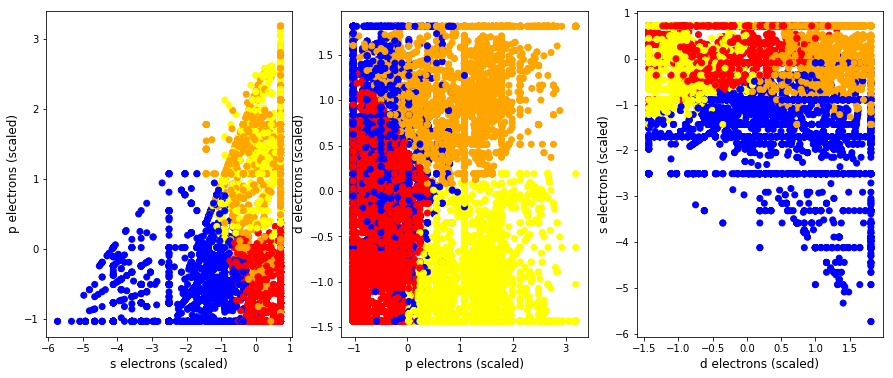

In [823]:
cluster_labels = kmeans.labels_
color_dict = {0:'orange',1:'red',2:'blue',3:'yellow'}

plt.figure(figsize=(15,6))
plt.subplot(1,3,1)
plt.scatter(mat_val_scaled[:,0],mat_val_scaled[:,1],color=[color_dict[label] for label in cluster_labels])
plt.xlabel('s electrons (scaled)',fontsize=12)
plt.ylabel('p electrons (scaled)',fontsize=12)
plt.subplot(1,3,2)
plt.scatter(mat_val_scaled[:,1],mat_val_scaled[:,2],color=[color_dict[label] for label in cluster_labels])
plt.xlabel('p electrons (scaled)',fontsize=12)
plt.ylabel('d electrons (scaled)',fontsize=12)
plt.subplot(1,3,3)
plt.scatter(mat_val_scaled[:,2],mat_val_scaled[:,0],color=[color_dict[label] for label in cluster_labels])
plt.xlabel('d electrons (scaled)',fontsize=12)
plt.ylabel('s electrons (scaled)',fontsize=12)
plt.show()                

Unfortunately, this visual is not particularly informative. Alternately we could project the 3 feature dimensions to two dimensions using PCA and then visualize the clusters. To compare visually the position of the above four elements (Si, K, S, Cr) we will need to obtain the scaled coordinates of these points. We can then transform these coordinates to two dimensions using PCA and plot them on the same graph.

In [840]:
#Create a PCA object and fit and transform scaled feature matrix
pca = PCA(n_components=3)
two_d_mat_val_db = pca.fit_transform(mat_val_scaled)

#Append projected features to materials database
materials_db['proj_dim_1'] = two_d_mat_val_db[:,1]
materials_db['proj_dim_2'] = two_d_mat_val_db[:,2]

# Si closest to cluster 1 has material id mp-109
projected_Si_coordinates = materials_db[materials_db['material_id']=='mp-109']\
                                      [['proj_dim_1','proj_dim_2']].values[0]

# K closest to cluster 2 has material id mp-1199937
projected_K_coordinates = materials_db[materials_db['material_id']=='mp-1199937']\
                                      [['proj_dim_1','proj_dim_2']].values[0]

# S closest to cluster 3 has material id mp-10869
projected_S_coordinates = materials_db[materials_db['material_id']=='mp-10869']\
                                      [['proj_dim_1','proj_dim_2']].values[0]

# Cr closest to cluster 4 has material id mp-89
projected_Cr_coordinates = materials_db[materials_db['material_id']=='mp-89']\
                                      [['proj_dim_1','proj_dim_2']].values[0]

It is also useful to plot the cluster centers for reference

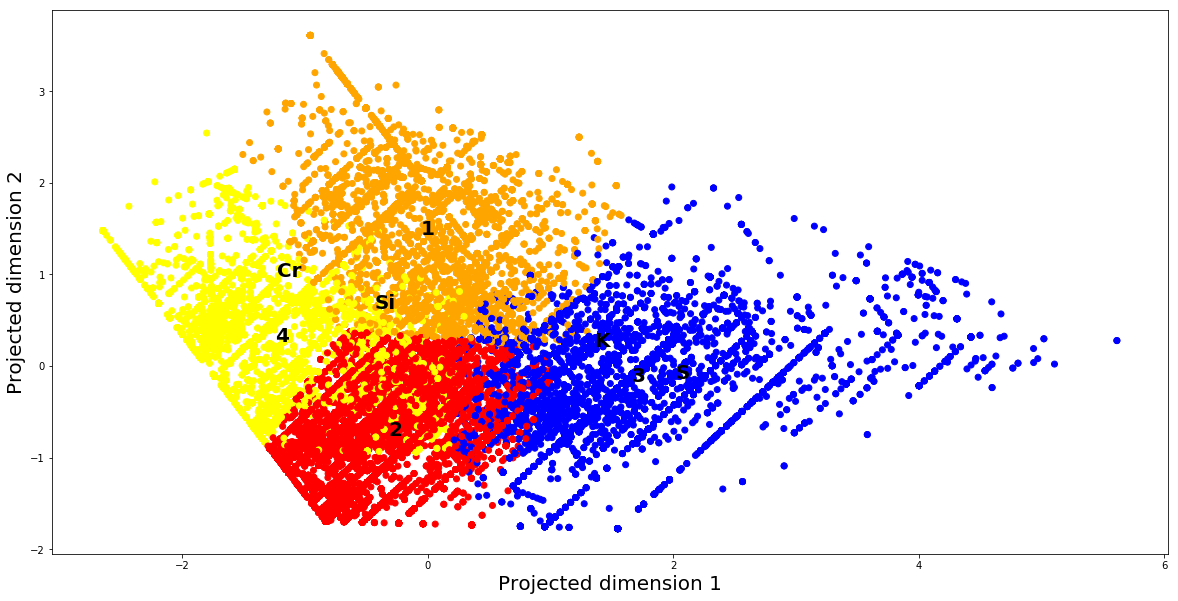

In [841]:
cluster_centers = kmeans.cluster_centers_
cluster_centers_pca = pca.transform(cluster_centers) #transform cluster center coordinates to projected dimensions

plt.figure(figsize=(20,10))
plt.scatter(two_d_mat_val_db[:,0],two_d_mat_val_db[:,1],color=[color_dict[label] for label in cluster_labels])

# Plot Si coordinates in black
plt.text(projected_Si_coordinates[0],projected_Si_coordinates[1],'Si',color='black',fontsize=20,weight="bold")

# Plot K coordinates in black
plt.text(projected_K_coordinates[0],projected_K_coordinates[1],'K',color='black',fontsize=20,weight="bold")
         
# Plot S coordinates in black
plt.text(projected_S_coordinates[0],projected_S_coordinates[1],'S',color='black',fontsize=20,weight="bold")
         
# Plot Cr coordinates in black
plt.text(projected_Cr_coordinates[0],projected_Cr_coordinates[1],'Cr',color='black',fontsize=20,weight="bold")

plt.xlabel('Projected dimension 1',fontsize=20)
plt.ylabel('Projected dimension 2',fontsize=20)


for cluster_count,cluster_center in enumerate(cluster_centers_pca):
    plt.text(cluster_center[0],cluster_center[1],str(cluster_count+1),color='black',fontsize=20,weight="bold")
    
plt.show()

We can now answer question 4 - Given a target material, say Copper, what is the material (unary, binary and ternary respectively) whose electronic structure most closely resembles that of Copper?  

To answer this question, we first find the material-id corresponding to ground state copper (mp-30). Using this material id, we can extract the scaled coordinates of copper. 

In [862]:
Cu_coordinates = materials_db[materials_db['material_id']=='mp-30'][valence_columns]

Next, we can compute pairwise distances using the corresponding function in sklearn. We can then assign a column in the dataset to these distances and sort by distance to find the materials most similar to Copper.

In [863]:
distances_to_Cu = pairwise_distances(Y=Cu_coordinates,X=materials_db[valence_columns],metric='euclidean')
materials_db['distances_to_Cu'] = distances_to_Cu
materials_db.sort_values(by=['distances_to_Cu'],ascending=True,axis=0,inplace=True)
materials_db[['material_id','nsites','pretty_formula','distances_to_Cu']].head(100)

,material_id,nsites,pretty_formula,distances_to_Cu
0,mp-8566,4,Ag,0.000000
480,mp-1183224,4,AgAu3,0.000000
479,mp-1183137,4,Ag3Au,0.000000
478,mp-863750,4,AgAu3,0.000000
477,mp-1229092,2,AgAu,0.000000
476,mp-985287,8,AgAu3,0.000000
475,mp-1183227,2,AgAu,0.000000
12669,mp-1096217,4,CdPdAu2,0.000000
9866,mp-1093618,4,Cu2AgAu,0.000000
131,mp-989695,4,Cu,0.000000


The elemental solids closest to Copper are Silver and Gold respectively, which matches chemical intuition perfectly.
In fact, this result is guaranteed by the fact that we use average valence electronic structure for our features. Since Ag and Silver have the same valence electronic structure (they belong to the same column on the periodic table) it is therefore to be expected that they are close neighbors in this scheme.  

While several binary metals are close to Cu, following the reasoning from the previous paragraph it is perhaps obvious that alloys of Ag, Au and Cu will have an identical electronic structure.

The ternary material closest to Cu, unsurprisingly is also an alloy of Cu, Ag and Au together. The unexpected results are those of HgPd and ZnPd - an alloy of Mercury and Zinc respectively with Palladium. The electronic structure of these materials is dissimilar to Copper. In a limited sense, it can thus be said we have performed materials discovery using computational tools!

Moving on to question 5 - Given a target material, say Copper, what is the (binary and ternary) nitride material whose electronic structure most closely resembles that of Copper? 

We first filter out those materials that don't contain N atoms in them

In [710]:
N_materials = materials_db[['N' in element_list for element_list in materials_db['elements'].tolist()]].copy()

Next, we compute pairwise distances in the N_materials dataframe to the Copper coordinates and assign it to a column in the dataframe

In [858]:
distance_nitrides_to_Cu = pairwise_distances(X=N_materials[valence_columns],Y=Cu_coordinates,metric='euclidean')
N_materials['distance_nitrides_to_Cu'] = distance_nitrides_to_Cu

Finally, we sort the dataframe by distances to Copper and print out the top results in the resulting dataframe 

In [861]:
N_materials.sort_values(by='distance_nitrides_to_Cu',inplace=True,axis=0,ascending=True)
N_materials[['material_id','nsites','pretty_formula','distance_nitrides_to_Cu']].head(50)

,material_id,nsites,pretty_formula,distance_nitrides_to_Cu
20055,mp-1206517,5,Cu3PdN,0.905804
20059,mp-1225808,40,Cu31PdN8,1.067079
20058,mp-1225725,9,Cu6PdN2,1.068271
20064,mp-1207194,5,Cu3RhN,1.192107
20062,mp-1188468,17,Cu12PdN4,1.207957
12705,mp-1225700,9,Cu6AuN2,1.235313
20065,mp-1207091,5,Cu3RuN,1.235422
3802,mp-1225831,13,Cu10N3,1.282825
20061,mp-1188488,16,Cu11PdN4,1.283454
20063,mp-1181591,16,Cu11PdN4,1.283454


If we remove from consideration those materials that contain Cu, Ag and Au, we can select Mo$_3$Pd$_2$N. While a more detailed analysis is then required to ascertain if this material satisfies the requirements of a diffusion barrier material, such an analysis can serve as a good starting point for screening materials based on electronic configuration similarity.

### Conclusion
That brings us to the end of this post. The information and analysis provided above should serve as a blueprint for further investigation into similar topics. The choice of VEC as features for unsupervised learning and analyzing similarity was motivated by the need to keep the post accessible to a broad audience. A number of such features can be created from the materials data based on material composition and structure. A larger list of featurizers cn be accessed at the relevant <a href = "https://hackingmaterials.github.io/matminer/featurizer_summary.html">matminer table of featurizers</a>. 

Creating a good set of features for the problem at hand is often the most important step in such computational materials discovery. It is also an important part of a new sub-field in Computational Materials Science called Materials Informatics. The field of materials discovery using informatics is still nascent, but bound to grow rapidly and data-driven techniques make their way into every industry. There are a number of interesting and industrially relevant materials-related questions that can be answered when one has access to this kind of information. 